In [7]:
!pip install ultralytics opencv-python

In [8]:
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow


In [9]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # You can use yolov8s.pt for better accuracy

from google.colab import files
uploaded = files.upload()

# -------- Step 1: Load Image --------
image_path = "road.jpg"  # <-- replace with your image filename
frame = cv2.imread(image_path)
if frame is None:
    raise Exception("Image not found! Check your path.")


Saving road.jpg to road (2).jpg



0: 384x640 8 cars, 3 traffic lights, 160.5ms
Speed: 5.4ms preprocess, 160.5ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


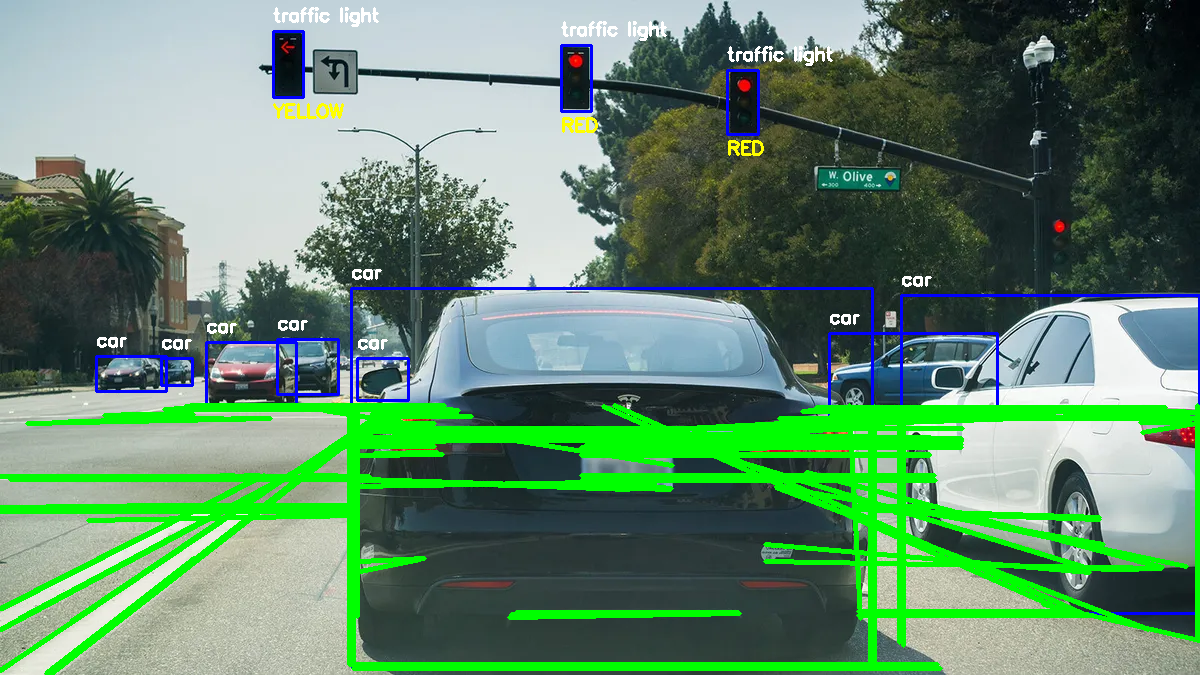

In [10]:
# -------- Step 2: Lane Detection --------
def detect_lane(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    mask = np.zeros_like(edges)
    h, w = edges.shape
    polygon = np.array([[
        (0, h),
        (w, h),
        (w, int(h*0.6)),
        (0, int(h*0.6))
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    cropped = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(cropped, 1, np.pi/180, 50, minLineLength=50, maxLineGap=100)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(frame, (x1,y1), (x2,y2), (0,255,0), 3)
    return frame

# -------- Step 3: Traffic Light Color Detection --------
def detect_traffic_light_color(roi):
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    red = cv2.inRange(hsv, (0,120,120), (10,255,255))
    green = cv2.inRange(hsv, (40,120,120), (70,255,255))
    if cv2.countNonZero(red) > 50: return "RED"
    if cv2.countNonZero(green) > 50: return "GREEN"
    return "YELLOW"

# -------- Step 4: Object Detection (YOLO) --------
results = model(frame)
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        label = model.names[cls]
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(frame, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        if label == "traffic light":
            roi = frame[y1:y2, x1:x2]
            if roi.size != 0:
                color = detect_traffic_light_color(roi)
                cv2.putText(frame, color, (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)

# -------- Step 5: Add Lane Lines --------
frame = detect_lane(frame)

# -------- Step 6: Display Result --------
cv2_imshow(frame)

